# logistic Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# dataset
df = pd.read_csv("../dataset/satellite_signal_dataset.csv")
df

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,MEO,1.685713e+07,1.736510e+10,25.080678,2.432281,1.169748,7.858419,0.503750,0.000000,1.406217e+07,...,50.695909,44.337482,201.770993,13.247039,0.000000,55.080678,-65.407711,-103.565223,38.157512,Good
19996,GEO,3.662369e+07,1.381205e+10,25.290539,1.246480,1.311491,7.553688,1.224388,0.878952,4.593719e+07,...,42.900954,43.342553,206.522177,27.664392,6.897952,55.290539,-100.774864,-95.415555,-5.359309,Poor
19997,GEO,3.763953e+07,3.895861e+10,15.391389,1.109350,1.330595,5.611248,1.580649,0.000000,1.626594e+07,...,50.895523,52.475069,215.766724,53.323541,0.000000,45.391389,-121.908934,-100.613091,-21.295844,Poor
19998,LEO,9.881086e+05,7.779364e+09,18.686395,1.314725,0.650007,3.460211,0.559639,0.217036,4.571927e+07,...,38.377665,32.259328,170.156748,0.038710,0.032774,48.686395,-51.464481,-95.525621,44.061140,Good


In [3]:
# encoding the target 
labels, uniques = pd.factorize(df['signal_quality'])
X = pd.get_dummies(df.drop(columns=['signal_quality']), drop_first=True).values
y = labels

In [4]:
# train-test split
np.random.seed(42)
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8*len(X))
train_idx, test_idx = idx[:split], idx[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [5]:
# one-hot encoding
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train, len(np.unique(y)))
y_test_oh = one_hot(y_test, len(np.unique(y)))

In [6]:
# softmax logistic regression 
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def fit(self, X, y):
        X = X.astype(np.float64) # Explicitly cast X to float64
        m, n = X.shape
        k = y.shape[1]
        self.W = np.zeros((n, k))
        self.b = np.zeros((1, k))

        for _ in range(self.epochs):
            z = np.dot(X, self.W) + self.b
            probs = self.softmax(z)
            grad_W = np.dot(X.T, (probs - y)) / m
            grad_b = np.sum(probs - y, axis=0, keepdims=True) / m
            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

    def predict(self, X):
        X = X.astype(np.float64) # Explicitly cast X to float64 for prediction
        z = np.dot(X, self.W) + self.b
        probs = self.softmax(z)
        return np.argmax(probs, axis=1)

In [7]:
# applying Logistic...
model = LogisticRegression(lr=0.1, epochs=1000)
model.fit(X_train, y_train_oh)

In [8]:
# prediction on test set
y_pred = model.predict(X_test)

In [9]:
# evaluation metrics
accuracy = np.mean(y_pred == y_test)
precision, recall = [], []
for c in np.unique(y_test):
    tp = np.sum((y_pred == c) & (y_test == c))
    fp = np.sum((y_pred == c) & (y_test != c))
    fn = np.sum((y_pred != c) & (y_test == c))
    precision.append(tp / (tp + fp + 1e-9))
    recall.append(tp / (tp + fn + 1e-9))

print("Accuracy:", accuracy)
print("Precision per class:", precision)
print("Recall per class:", recall)

Accuracy: 0.8125
Precision per class: [np.float64(0.8124999999997968), np.float64(0.0), np.float64(0.0)]
Recall per class: [np.float64(0.9999999999996924), np.float64(0.0), np.float64(0.0)]


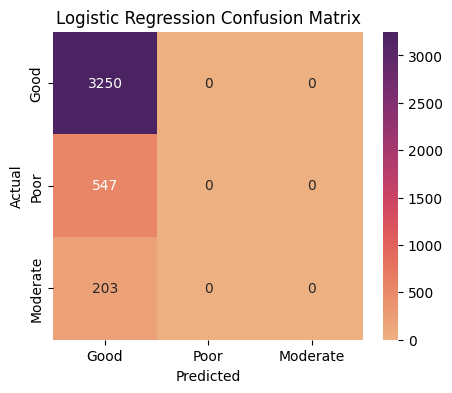

In [10]:
# confusion metrics
cm = np.zeros((len(np.unique(y_test)), len(np.unique(y_test))), dtype=int)
for t, p in zip(y_test, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=uniques, yticklabels=uniques)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### Plots

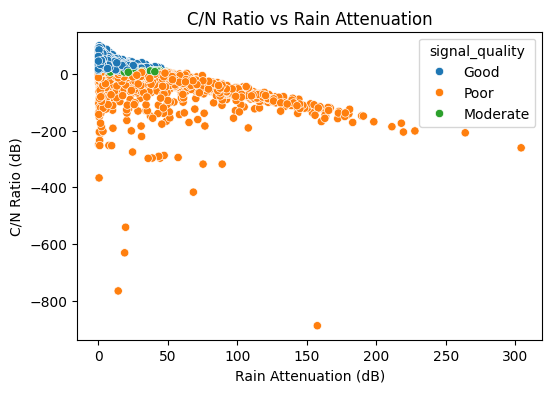

In [11]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['rain_attenuation_db'], y=df['cn_ratio_db'], hue=df['signal_quality'])
plt.xlabel("Rain Attenuation (dB)")
plt.ylabel("C/N Ratio (dB)")
plt.title("C/N Ratio vs Rain Attenuation")
plt.show()

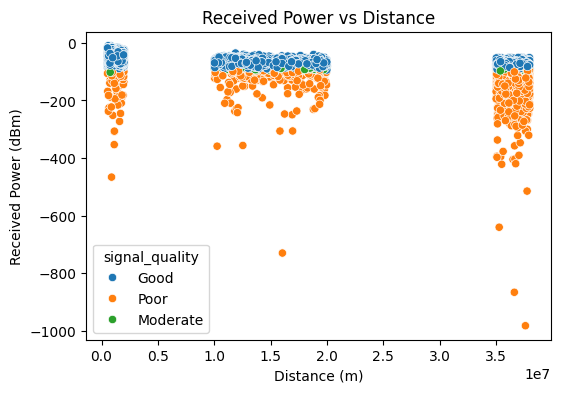

In [12]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['distance_m'], y=df['received_power_dbm'], hue=df['signal_quality'])
plt.xlabel("Distance (m)")
plt.ylabel("Received Power (dBm)")
plt.title("Received Power vs Distance")
plt.show()

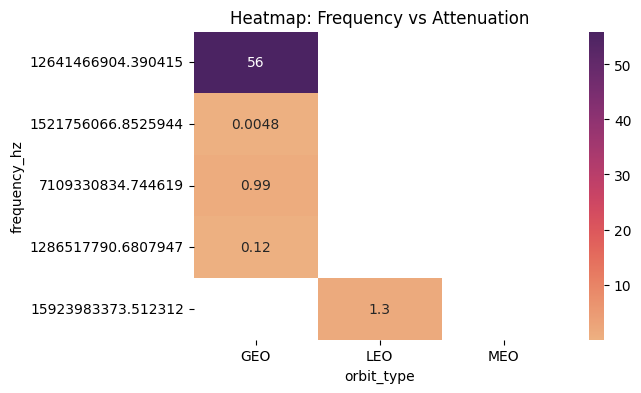

In [13]:
plt.figure(figsize=(6,4))
heatmap_data = df.pivot_table(values="rain_attenuation_db",
                              index="frequency_hz",
                              columns="orbit_type",
                              aggfunc="mean")
# Sample the heatmap data to reduce clutter on the y-axis
sampled_heatmap_data = heatmap_data.sample(n=5, random_state=42) # Sample 5 frequencies

sns.heatmap(sampled_heatmap_data, cmap="flare", annot=True)
plt.title("Heatmap: Frequency vs Attenuation")
plt.show()